# Data Prep

In [30]:
import matplotlib.pyplot as plt
import math

def parseInput():
    with open("lock_BuzzBlogBenchmark_2021-12-02-00-05-43.log") as f:
        lines = f.readlines()
        index = 0
        indexSpin = 0
        indexHold = 0
        indexHeldTime = 0
        indexSpinTime = 0
        while True:
            words = lines[index].split()
            if words:
                if words[0] == "Caller":
                    if indexSpin == 0:
                        indexSpin = index
                    elif indexHold == 0:
                        indexHold = index
                if words[0] == "Start":
                    if indexHeldTime == 0:
                        indexHeldTime = index
                    elif indexSpinTime == 0:
                        indexSpinTime = index
                        break
            index += 1
        spinData = lines[indexSpin+1:indexHold-1]
        holdData = lines[indexHold+1:indexHeldTime-3]
        heldTimeData = lines[indexHeldTime+1:indexSpinTime-4]
        spinTimeData = lines[indexSpinTime+1:]
        return spinData, holdData, heldTimeData, spinTimeData

SPIN_DATA , HOLD_DATA, HELD_TIME_DATA, SPIN_TIME_DATA = parseInput()

# Helper Functions

In [31]:
def inputToMap(inputData):
    mp = {}
    for lines in inputData:
        words = lines.split()
        index = 0
        flag = -1
        while index < len(words):
            if not words[index].isnumeric():
                if not (words[index][-1] == '\'' or words[index][-1] == ']'):
                    flag = index
                    words[index] += " " + words[index+1]
                    words.pop(index+1)
                else:
                    index += 1
            else:
                if index >= 2:
                    break
                index += 1      
        if words[2] in mp:
            old = mp[words[2]]
            mp[words[2]] = {'pid': int(words[2]), 'name': words[1], 'totalSpin': old['totalSpin'] + int(words[-1]), 'count': old['count'] + int(words[-3])}
        else:
            mp[words[2]] = {'pid': int(words[2]), 'name': words[1], 'totalSpin': int(words[-1]), 'count': int(words[-3])}
    return mp

def inputToTimeXY(time_data):
    mp = {}
    for line in time_data:
        words = line.split()
        if int(words[0]) in mp:
            mp[int(words[0])] += 1
        else:
            mp[int(words[0])] = 1
        if int(words[1]) > 0:
            if int(words[1]) in mp:
                mp[int(words[1])] -= 1
            else:
                mp[int(words[1])] = -1
        elif int(words[1]) < 0:
            mp[int(words[0])] -= 1
    mp = dict(sorted(mp.items()))
    x = list(mp.keys())
    y = list(mp.values())
    for i in range(len(y)):
        if i > 0:
            y[i] += y[i-1]
    return x,y

# Plotting Helpers

In [32]:
def plot(plotData, xlabel, ylabel, title, start):
    combined = {}
    for v in plotData.values():
        combined[str(v['pid']) + " " + v['name']] = v['totalSpin'] // v['count']
    combined = dict(sorted(combined.items(), key=lambda item: item[1]))
    if abs(start) > len(list(combined.keys())):
        start = 0
    x = list(combined.keys())[start:]
    y = list(combined.values())[start:]
    plt.xticks(rotation = 90)
    plt.xlabel(xlabel=xlabel)
    plt.ylabel(ylabel=ylabel)
    plt.title(title)
    plt.yscale('log')
    plt.tight_layout()
    plt.plot(x, y)
    plt.close()

def plot_time(x, y, title, ylabel):
    x = [i / 1e9 for i in x]
    end = x[-1]
    xt = range(0, math.ceil(end), 50)
    plt.figure(figsize=(24,12))
    plt.xlabel("Time (in ms)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.plot(x, y, ds='steps-post')
    plt.close()

# Processes that are trying to acquire Locks

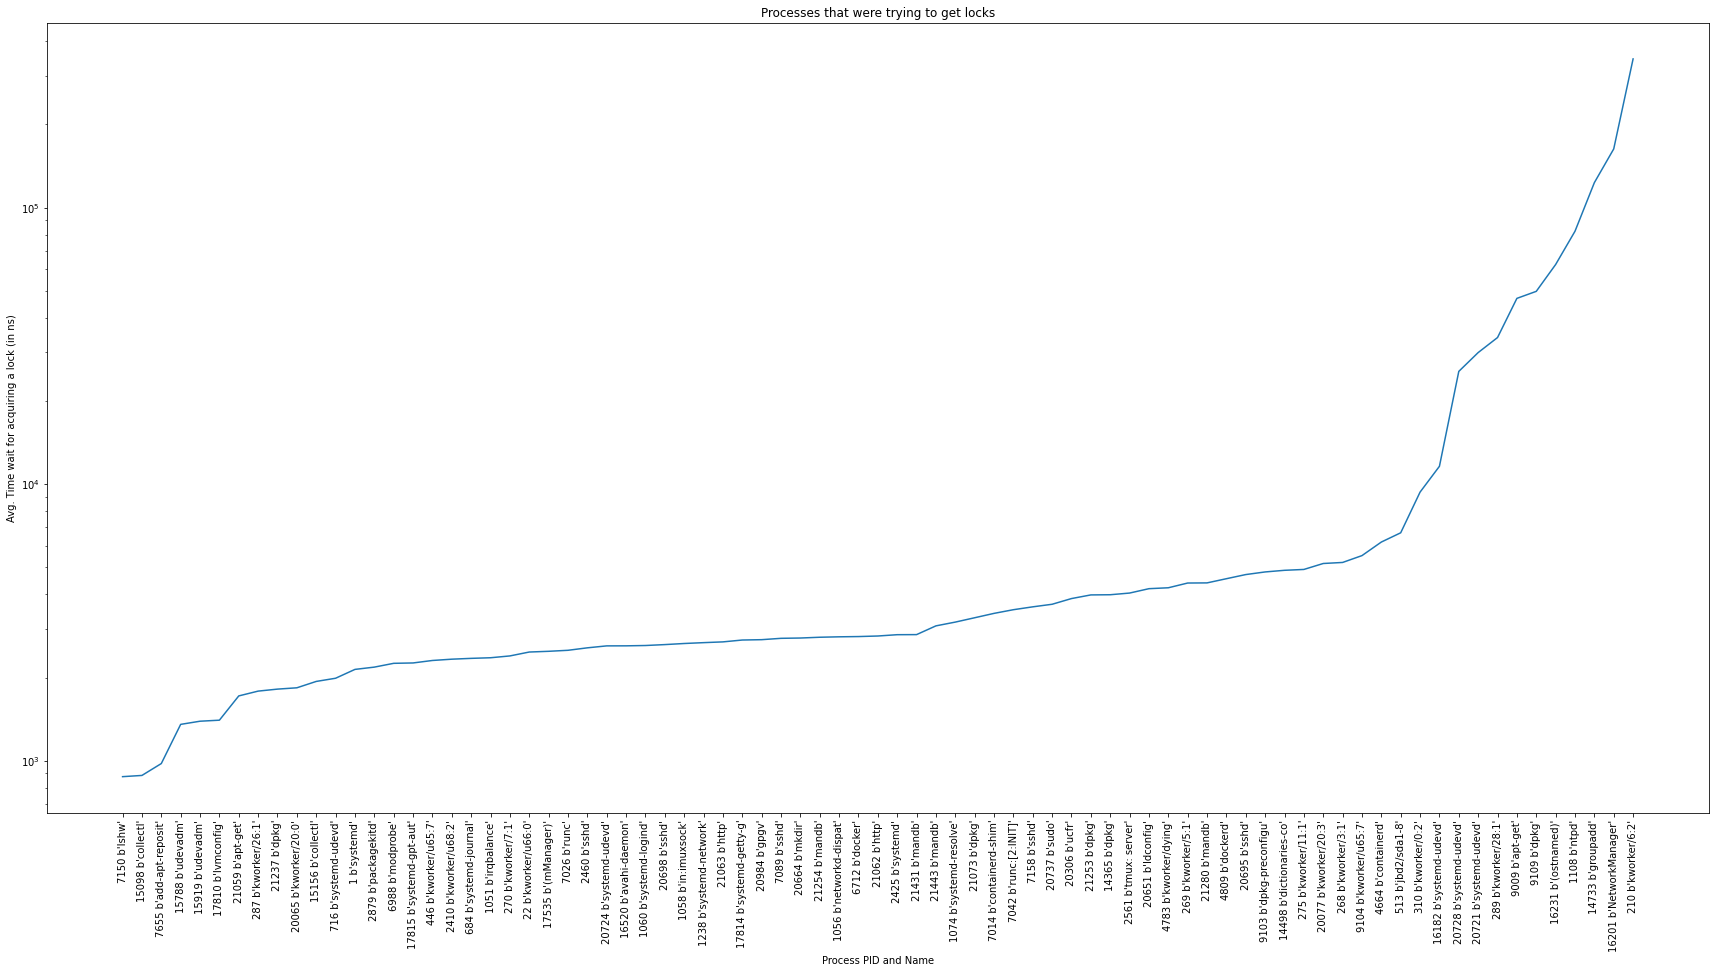

In [33]:
SPIN_MAP = inputToMap(SPIN_DATA)
combined = {}
for v in SPIN_MAP.values():
    combined[str(v['pid']) + " " + v['name']] = v['totalSpin'] // v['count']
combined = dict(sorted(combined.items(), key=lambda item: item[1]))
x = list(combined.keys())
y = list(combined.values())
plt.figure(figsize=(24, 12))
plt.xticks(rotation = 90)
plt.xlabel(xlabel="Process PID and Name")
plt.ylabel(ylabel="Avg. Time wait for acquiring a lock (in ns)")
plt.title("Processes that were trying to get locks")
plt.yscale('log')
plt.tight_layout()
plt.plot(x, y)
# plt.close()

In [34]:
plt.close()

# Processes that are holding locks

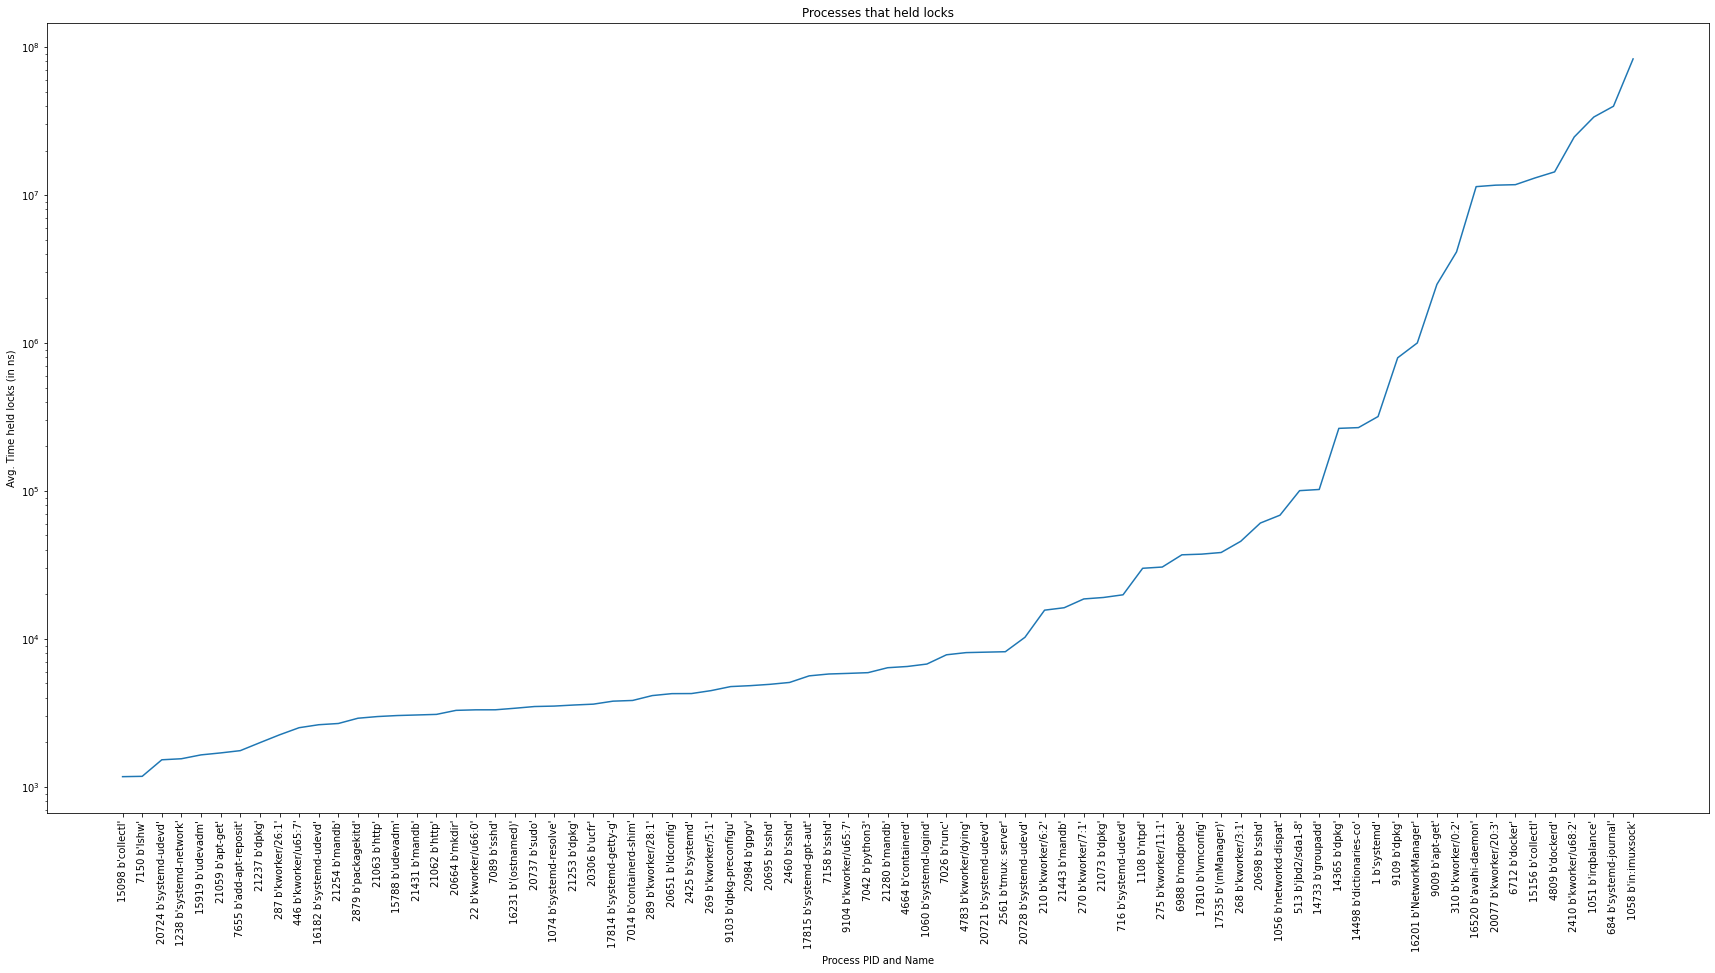

In [35]:
HOLD_MAP = inputToMap(HOLD_DATA)
combined = {}
for v in HOLD_MAP.values():
    combined[str(v['pid']) + " " + v['name']] = v['totalSpin'] // v['count']
combined = dict(sorted(combined.items(), key=lambda item: item[1]))
x = list(combined.keys())
y = list(combined.values())
plt.figure(figsize=(24, 12))
plt.xticks(rotation = 90)
plt.xlabel(xlabel="Process PID and Name")
plt.ylabel(ylabel="Avg. Time held locks (in ns)")
plt.title("Processes that held locks")
plt.yscale('log')
plt.tight_layout()
plt.plot(x, y)

In [36]:
plt.close()

# Number of Processes that are trying to acquire locks v/s time

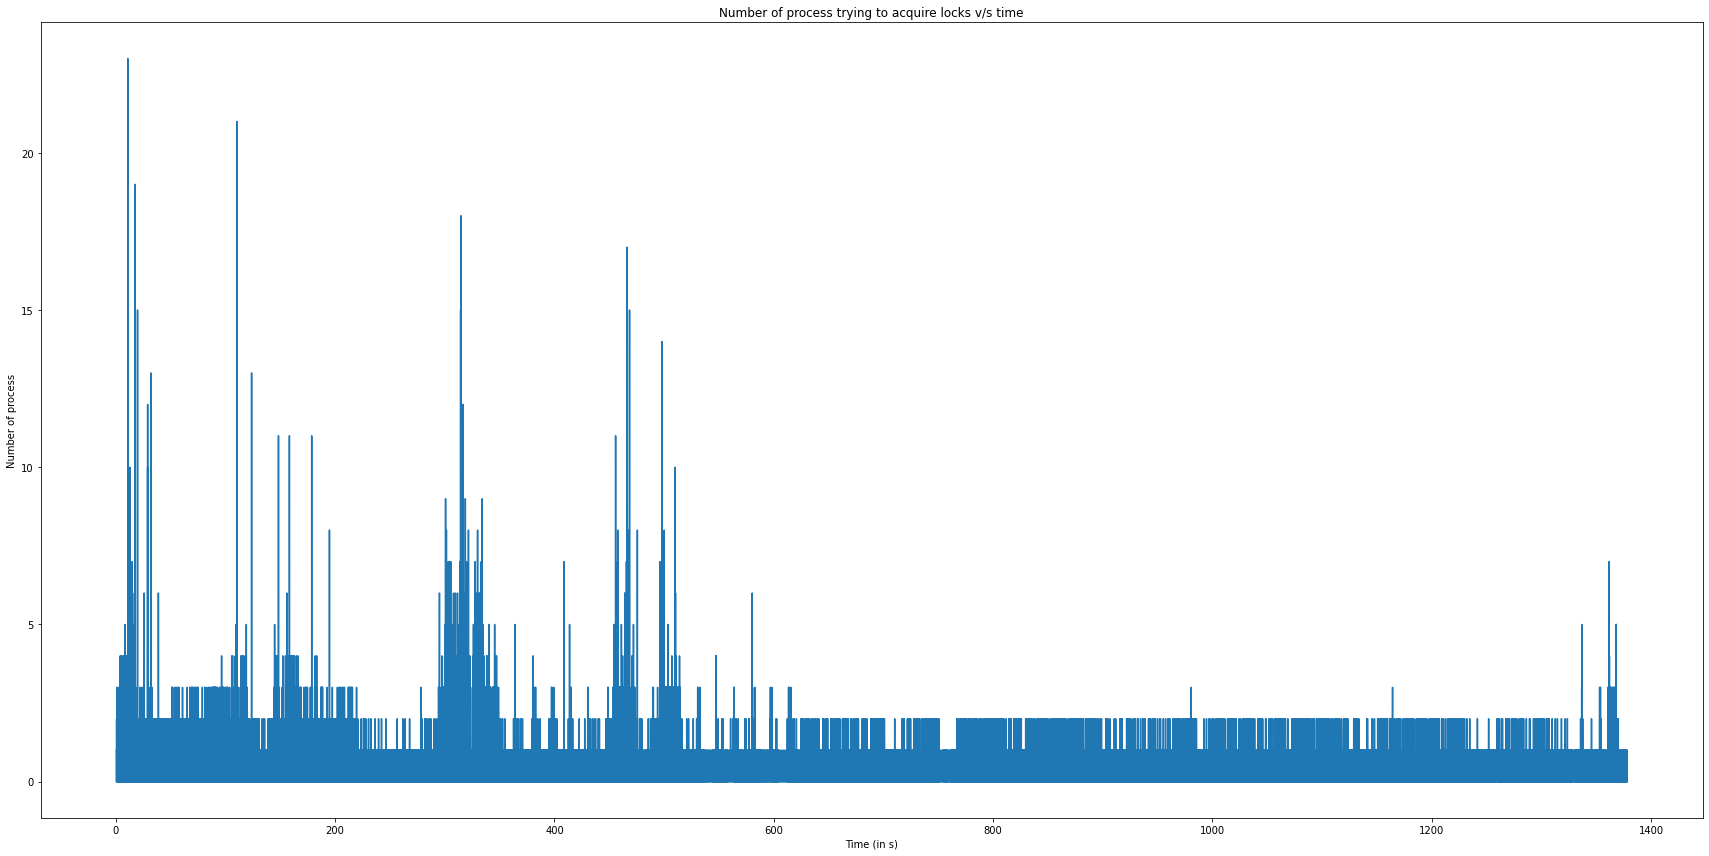

In [37]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

SPIN_TIME_X, SPIN_TIME_Y = inputToTimeXY(SPIN_TIME_DATA)
SPIN_TIME_X = [i / 1e9 for i in SPIN_TIME_X]
end = SPIN_TIME_X[-1]
mp = dict(zip(SPIN_TIME_X, SPIN_TIME_Y))
if MIN_TIME is not None:
    mp = {k: v for k,v in mp.items() if k >= MIN_TIME}
if MAX_TIME is not None:
    mp = {k: v for k,v in mp.items() if k <= MAX_TIME}
xt = range(0, math.ceil(end), 50)
plt.figure(figsize=(24,12))
plt.xlabel("Time (in s)")
plt.ylabel("Number of process")
plt.title("Number of process trying to acquire locks v/s time")
plt.tight_layout()
plt.plot(mp.keys(), mp.values(), ds='steps-post')

In [38]:
plt.close()

# Number of Processes that are holding locks v/s time

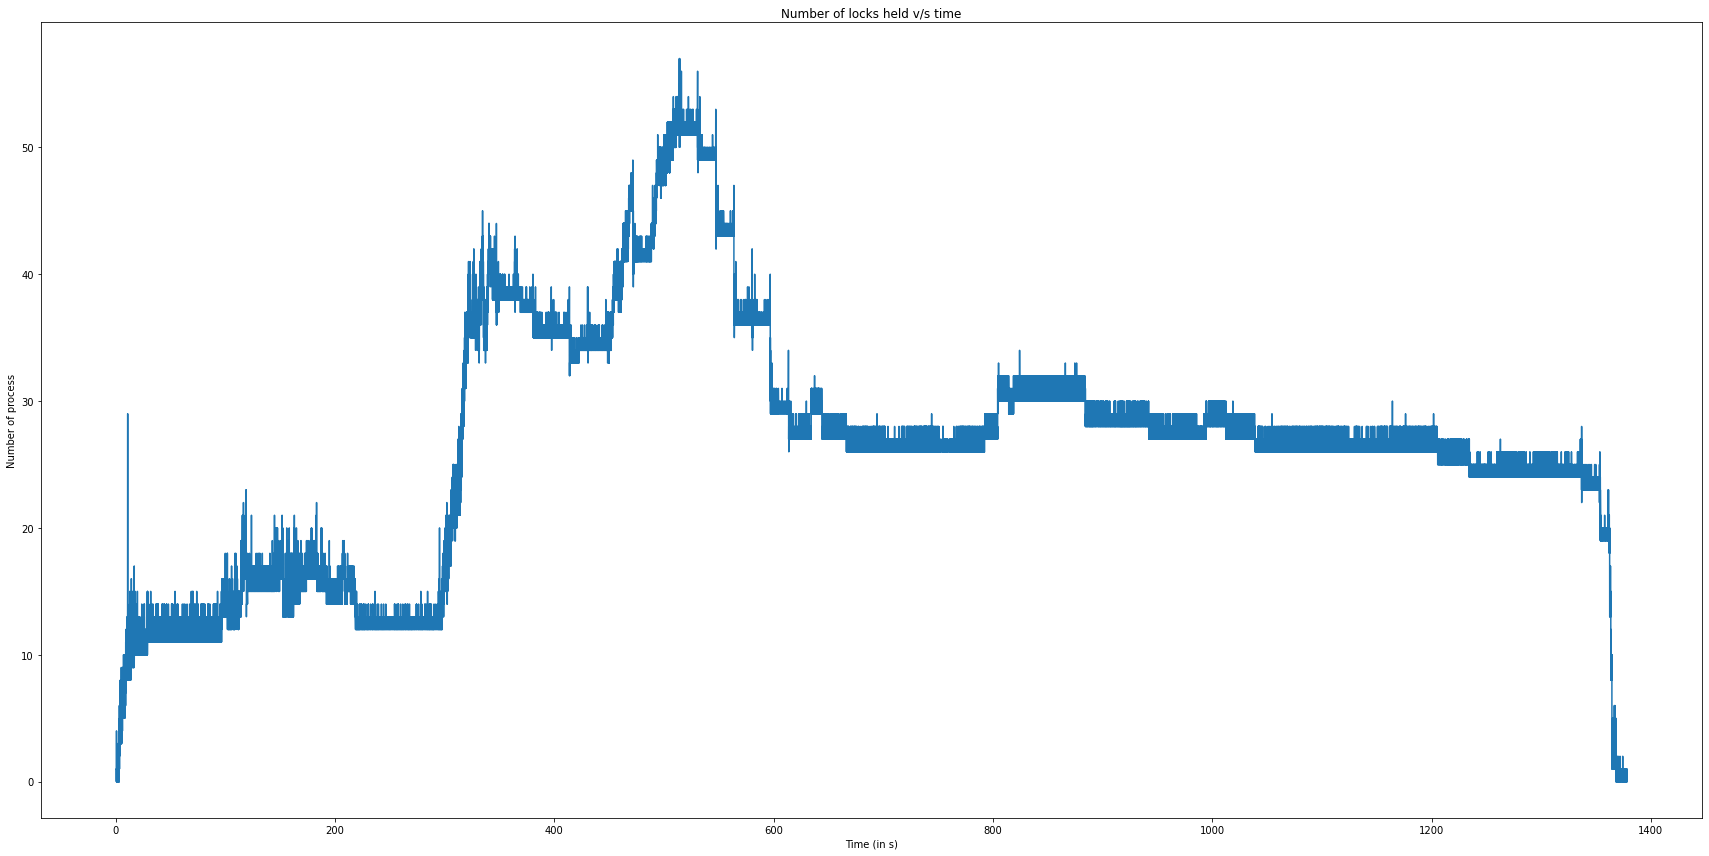

In [39]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

HELD_TIME_X, HELD_TIME_Y = inputToTimeXY(HELD_TIME_DATA)
HELD_TIME_X = [i / 1e9 for i in HELD_TIME_X]
end = HELD_TIME_X[-1]
mp = dict(zip(HELD_TIME_X, HELD_TIME_Y))
if MIN_TIME is not None:
    mp = {k: v for k,v in mp.items() if k >= MIN_TIME}
if MAX_TIME is not None:
    mp = {k: v for k,v in mp.items() if k <= MAX_TIME}
xt = range(0, math.ceil(end), 50)
plt.figure(figsize=(24,12))
plt.xlabel("Time (in s)")
plt.ylabel("Number of process")
plt.title("Number of locks held v/s time")
plt.tight_layout()
plt.plot(mp.keys(), mp.values(), ds='steps-post')

In [40]:
plt.close()